In [30]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("navoneel/brain-mri-images-for-brain-tumor-detection")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/brain-mri-images-for-brain-tumor-detection


In [34]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Step 1: Attention Block
def attention_block(inputs):
    x = GlobalAveragePooling2D()(inputs)
    x = Dense(inputs.shape[-1] // 8, activation='relu')(x)
    x = Dense(inputs.shape[-1], activation='sigmoid')(x)
    x = Reshape((1, 1, inputs.shape[-1]))(x)
    return Multiply()([inputs, x])

# Step 2: Improved CNN + Attention Model
def build_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = attention_block(x)

    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    return Model(inputs, outputs)

# Step 3: Dataset Setup
image_size = 128
batch_size = 32
data_path = Path("/kaggle/input/brain-mri-images-for-brain-tumor-detection")  # Replace if needed

# Data Augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True
)

train_generator = datagen.flow_from_directory(
    data_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    data_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Step 4: Train Model
model = build_model((image_size, image_size, 3), num_classes=3)
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping to avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model.fit(train_generator, epochs=15, validation_data=val_generator, callbacks=[early_stop])
model.save("brain_tumor_model.h5")

# Step 5: Prediction Function
def predict_image(img_path):
    img = Image.open(img_path).resize((image_size, image_size)).convert("RGB")
    img_array = np.array(img).astype("float32") / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    class_names = list(train_generator.class_indices.keys())
    predicted_class = class_names[np.argmax(prediction)]

    plt.imshow(img)
    plt.title(f"Prediction: {predicted_class}")
    plt.axis('off')
    plt.show()


Found 406 images belonging to 3 classes.
Found 100 images belonging to 3 classes.
Epoch 1/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.3924 - loss: 1.9458 - val_accuracy: 0.3300 - val_loss: 1.1461
Epoch 2/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.4443 - loss: 1.3200 - val_accuracy: 0.2900 - val_loss: 1.3427
Epoch 3/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.4692 - loss: 1.0517 - val_accuracy: 0.2000 - val_loss: 1.5588
Epoch 4/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.4938 - loss: 0.9571 - val_accuracy: 0.1900 - val_loss: 1.7924


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


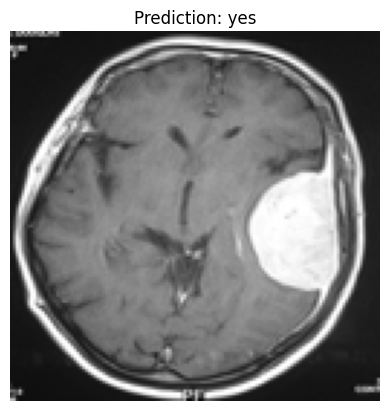

In [36]:
predict_image("/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes/Y103.jpg")
